In [1]:
%matplotlib inline

from math import prod, inf
import numpy as np
from mugnier.libs import backend
from mugnier.libs.quantity import Quantity as __
from mugnier.heom.hierachy import ExtendedDensityTensor, SineExtendedDensityTensor, Hierachy, SineHierachy
from mugnier.heom.bath import BoseEinstein, Drude, DiscreteVibration
from mugnier.operator.spo import Integrator
from mugnier.basis.dvr import SineDVR

from matplotlib import pyplot as plt


/home/vinylogy/miniforge3/envs/mkl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def test_hierachy_coh(scale, use_dvr = True):
    # System settings:
    e = __(5000, '/cm').au
    v = __(0, '/cm').au
    h = backend.array([[0, v], [v, e]])
    op = backend.array([[0.0, 0.0], [0.0, 1.0]])
    rdo = backend.array([[0.5, 0.5], [0.5, 0.5]])

    # Bath settings:
    dummy_bath = False
    # beta = __(1 / 300, '/K').au
    beta = None
    distr = BoseEinstein(n=0, beta=beta)
    # corr = Drude(__(0, '/cm').au, __(50, '/cm').au, distr)
    corr = DiscreteVibration(__(550, '/cm').au, __(500, '/cm').au, distr)
    k_max = corr.k_max if not dummy_bath else 0
    corr.print()

    # basis settings:
    dim = 64
    start, stop = (-32, 32)
    Hierachy.scale_factor = scale

    # HEOM settings:
    if not use_dvr:
        Hierachy.scale_factor = scale
        heom_op = Hierachy(h, op, corr, [dim] * k_max)
        s = ExtendedDensityTensor(rdo, [dim] * k_max)
    else:
        SineHierachy.scale_factor = scale
        heom_op = SineHierachy(h, op, corr, [(start, stop, dim)] * k_max)
        s = SineExtendedDensityTensor(rdo, [(start, stop, dim)] * k_max)
    
    solver = Integrator(heom_op, s)

    func = solver.split_diff(s.root)
    d_norm = np.linalg.norm(func(s[s.root]).cpu().numpy())
    print('Derivative norm:', d_norm)

    length = prod(s.shape(s.root))
    return solver.split_diff_op(s.root).reshape((length, length))



Correlation coefficents:
            c: [5.19004773e-06+0.j 0.00000000e+00+0.j];
            (c* = [0.00000000e+00+0.j 5.19004773e-06+0.j];)
            gamma: [0.-0.00250598j 0.+0.00250598j].
        
0: fk=1.0; fk^(-1)=1.0.
1: fk=1.0; fk^(-1)=1.0.
Derivative norm: 0.016109078609535574


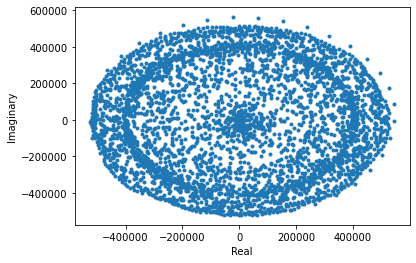

In [3]:
diff = test_hierachy_coh(1.0, use_dvr=False).cpu().numpy()
l = np.linalg.eigvals(diff)
re, im = l.real, l.imag
re = [__(r).convert_to('/cm').value for r in re]
im = [__(i).convert_to('/cm').value for i in im]
plt.plot(re, im, '.')
# plt.xlim(-1, 1)
# plt.ylim(-1.5, 1.5)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()

Correlation coefficents:
            c: [5.19004773e-06+0.j 0.00000000e+00+0.j];
            (c* = [0.00000000e+00+0.j 5.19004773e-06+0.j];)
            gamma: [0.-0.00250598j 0.+0.00250598j].
        
0: fk=(-0-1j); fk^(-1)=(-0+1j).
1: fk=(-0-1j); fk^(-1)=(-0+1j).
Derivative norm: 0.016109078609535574


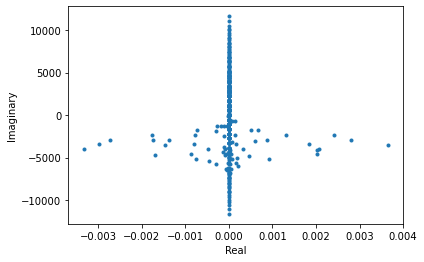

In [ ]:
diff = test_hierachy_coh(scale=1.0, use_dvr=True).cpu().numpy()
l = np.linalg.eigvals(diff)
re, im = l.real, l.imag
re = [__(r).convert_to('/cm').value for r in re]
im = [__(i).convert_to('/cm').value for i in im]
plt.plot(re, im, '.')
# plt.xlim(-1, 1)
# plt.ylim(-1.5, 1.5)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()